In [1]:
cd /content/drive/MyDrive/HTR

/content/drive/MyDrive/HTR


In [2]:
!ls

AuthorsDatasetFromDictionary.py     model_iam_epoch95.pt
contrastiveCosineSiameseNetwork.py  model_iam_epoch96.pt
ContrastiveLoss.py		    model_iam_EuclideanContrastive.pt
ContrastiveLossWithCosine.py	    __pycache__
contrastiveSiameseNetwork.py	    SimpleSiameseBCELogit.py
model_iam_BCELogit.pt		    testTop100_1000.txt
model_iam_epoch84.pt		    Top100Clean
model_iam_epoch86.pt		    trainTop100_10000.txt
model_iam_epoch90.pt		    validTop100_1000.txt


In [3]:
from time import sleep
from threading import Thread
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from contrastiveSiameseNetwork import *
from ContrastiveLoss import *
from torchsummary import summary
from matplotlib import pyplot as plt
from AuthorsDatasetFromDictionary import *
!pip install hdf5storage
import hdf5storage

     |████████████████████████████████| 61kB 3.2MB/s 


In [4]:
torch.cuda.is_available()

True

In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Sun May  9 13:27:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
ImageDictionary = {}

folders = os.listdir(os.path.join('','Top100Clean'))
shuffleArray = folders
random.shuffle(shuffleArray) #inplace shuffling.

pt1ranges = (0,25)
pt2ranges = (25,50)
pt3ranges = (50,75)
pt4ranges = (75,100)
def readTo(shufflearray ,ranges,readinto):
    for folderId in range(ranges[0],ranges[1]):
        files = os.listdir(os.path.join('','Top100Clean',shufflearray[folderId])) 
        for file in files :
          readinto[os.path.join('','Top100Clean',shufflearray[folderId],file)] = io.imread(os.path.join('','Top100Clean',shufflearray[folderId],file))
        print(str(folderId) , "is done...")

pt1 = Thread(target = readTo, args = (shuffleArray,pt1ranges,ImageDictionary))
pt2 = Thread(target = readTo, args = (shuffleArray,pt2ranges,ImageDictionary))
pt3 = Thread(target = readTo, args = (shuffleArray,pt3ranges,ImageDictionary))
pt4 = Thread(target = readTo, args = (shuffleArray,pt4ranges,ImageDictionary))

pt1.start()
pt2.start()
pt3.start()
pt4.start()

pt1.join()
pt2.join()
pt3.join()
pt4.join()

75 is done...
0 is done...
50 is done...
25 is done...
1 is done...
51 is done...
76 is done...
52 is done...
2 is done...
77 is done...
26 is done...
53 is done...
78 is done...
3 is done...
27 is done...
79 is done...
54 is done...
28 is done...
4 is done...
55 is done...
80 is done...
81 is done...
5 is done...
29 is done...
6 is done...
56 is done...
82 is done...
30 is done...
57 is done...
7 is done...
31 is done...
83 is done...
8 is done...
58 is done...
32 is done...
59 is done...
9 is done...
84 is done...
10 is done...
85 is done...
60 is done...
11 is done...
33 is done...
61 is done...
34 is done...
86 is done...
62 is done...
87 is done...
12 is done...
35 is done...
63 is done...
88 is done...
13 is done...
64 is done...
36 is done...
14 is done...
65 is done...
15 is done...
37 is done...
89 is done...
66 is done...
38 is done...
90 is done...
67 is done...
16 is done...
39 is done...
91 is done...
68 is done...
92 is done...
17 is done...
69 is done...
40 is done...
18

In [7]:
root_dir='./'
pathTrain ='/content/drive/MyDrive/HTR/trainTop100_10000.txt'
pathValid ='/content/drive/MyDrive/HTR/validTop100_1000.txt'

# Constants from Authors100 dataset
MAXWIDTH = 2270
MAXHEIGHT = 200

train_ds = AuthorsDataset(
    root_dir=root_dir,
    path=pathTrain,
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        Threshold(177),
        ShiftAndCrop(200, random=True),
        Downsample(0.75),
    ]))
valid_ds  = AuthorsDataset(
    root_dir=root_dir,
    path=pathValid,
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        Threshold(177),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

In [8]:
## Initialize parameters
bs = 128
lr = 0.00006
threshold = 0.05
margin = 0.15
epochs = 100

In [9]:
## Initialize network
model = ContrastiveSiamese()
model = model.cuda()

In [10]:
## Initialize optimizer
optim = torch.optim.Adam(model.parameters(),lr=lr)

## Initialize loss
criterion = ContrastiveLoss(margin)

In [11]:
train_dl = DataLoader(train_ds,batch_size=bs)
valid_dl = DataLoader(valid_ds,batch_size=bs)

In [12]:
images1, images2, labels = next(iter(train_dl))
images1.shape

torch.Size([128, 1, 150, 150])

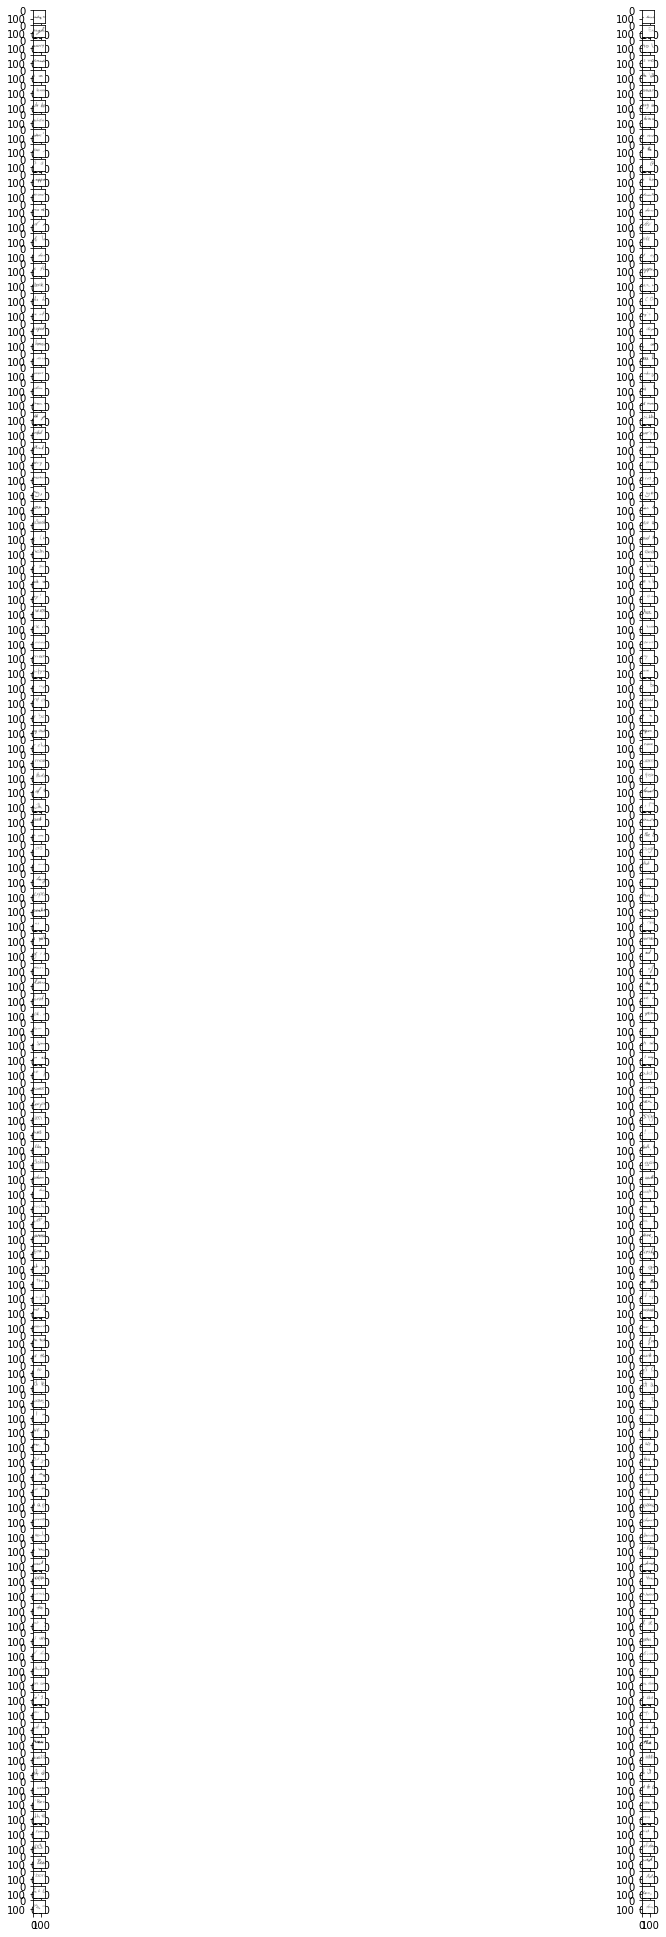

In [13]:
images1, images2, labels = next(iter(train_dl))
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,35)

fig, axs = plt.subplots(bs, 2)
for ii in range(bs):
    axs[ii, 0].imshow(torch.squeeze(images1[ii]), cmap ='gray')
    axs[ii, 1].imshow(torch.squeeze(images2[ii]), cmap ='gray')

In [14]:
def evaluate_pair(output1,output2,target,threshold):
    euclidean_distance = F.pairwise_distance(output1, output2)
    cond = euclidean_distance<threshold

    TruePositive = 0
    FalsePositive = 0
    TrueNegative = 0
    FalseNegative = 0



    for i in range(len(cond)):
        if target[i] == True and cond[i] == True:
            TruePositive += 1
        elif target[i] == True and cond[i] == False:
            FalseNegative +=1
        elif target[i] == False and cond[i] == True:
            FalsePositive +=1
        else:
            TrueNegative +=1
    return TruePositive,FalsePositive,TrueNegative,FalseNegative

In [ ]:
train_loss = []
valid_loss = []
valid_acc = []
valid_loss_min = np.Inf
for epoch in range(epochs):
    train_epoch_loss = 0
    model.train()    
      
    for i,(input1,input2,target) in enumerate(train_dl):
        optim.zero_grad()
        output1,output2 = model(input1.cuda(),input2.cuda())
        
        loss = criterion(output1,output2,target.cuda())
        train_epoch_loss += loss.item()
        loss.backward()
        optim.step()
    
    train_epoch_loss /= len(train_ds)
    train_loss.append(train_epoch_loss)
    
    print("Epoch [{}/{}] ----> Training loss :{} \n".format(epoch+1,epochs,train_epoch_loss))
    

    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),threshold)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)
    

    valid_loss.append(valid_epoch_loss)
    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)
    valid_acc.append(valid_acc_value)


    print("Validation loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n Validation Datasize: {}\n".format(valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value,len(valid_ds)))
    # save model if Training loss has decreased
    if valid_epoch_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min, valid_epoch_loss))
        torch.save(model.state_dict(), 'model_iam_EuclideanContrastive.pt')
        valid_loss_min = valid_epoch_loss

In [15]:
model = ContrastiveSiamese()
model.load_state_dict(torch.load('/content/drive/MyDrive/HTR/model_iam_EuclideanContrastive.pt'))
model = model.cuda()

In [16]:
valid_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/HTR/validTop100_1000.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        Threshold(177),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

valid_dl = DataLoader(valid_ds,batch_size=bs)


In [ ]:
tresholds = [0.005,0.004,0.003,0.002,0.001,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15]
for tr in tresholds :
    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),tr)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)



    print("Tresholds:{}\tTraining loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(tr,valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.005	Training loss :1.747250882908702e-05 			  TP: 1, TN: 500, FP: 0, FN: 499, Accuracy = 0.501

Tresholds:0.004	Training loss :1.747250882908702e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.003	Training loss :1.747250882908702e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.002	Training loss :1.747250882908702e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.001	Training loss :1.747250882908702e-05 			  TP: 0, TN: 500, FP: 0, FN: 500, Accuracy = 0.5

Tresholds:0.01	Training loss :1.747250882908702e-05 			  TP: 5, TN: 500, FP: 0, FN: 495, Accuracy = 0.505

Tresholds:0.02	Training loss :1.747250882908702e-05 			  TP: 63, TN: 499, FP: 1, FN: 437, Accuracy = 0.562

Tresholds:0.03	Training loss :1.747250882908702e-05 			  TP: 159, TN: 495, FP: 5, FN: 341, Accuracy = 0.654

Tresholds:0.04	Training loss :1.747250882908702e-05 			  TP: 242, TN: 476, FP: 24, FN: 258, Accuracy = 0.718

Tresholds:0.05	Training loss :1.74

In [ ]:
tresholds = [0.09,0.091,0.092,0.093,0.094,0.095,0.096,0.097,0.098,0.099]
for tr in tresholds :
    valid_epoch_loss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(valid_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        valid_epoch_loss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),tr)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    valid_epoch_loss /= len(valid_ds)

    valid_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(valid_ds)



    print("Tresholds:{}\tValid loss :{} \t\t\t  TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(tr,valid_epoch_loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,valid_acc_value))


Tresholds:0.09	Valid loss :1.7472498235292733e-05 			  TP: 488, TN: 408, FP: 92, FN: 12, Accuracy = 0.896

Tresholds:0.091	Valid loss :1.7472494975663722e-05 			  TP: 489, TN: 405, FP: 95, FN: 11, Accuracy = 0.894

Tresholds:0.092	Valid loss :1.7472494975663722e-05 			  TP: 490, TN: 402, FP: 98, FN: 10, Accuracy = 0.892

Tresholds:0.093	Valid loss :1.7472494975663722e-05 			  TP: 490, TN: 398, FP: 102, FN: 10, Accuracy = 0.888

Tresholds:0.094	Valid loss :1.7472494975663722e-05 			  TP: 491, TN: 395, FP: 105, FN: 9, Accuracy = 0.886

Tresholds:0.095	Valid loss :1.7472494975663722e-05 			  TP: 491, TN: 391, FP: 109, FN: 9, Accuracy = 0.882

Tresholds:0.096	Valid loss :1.7472494975663722e-05 			  TP: 493, TN: 390, FP: 110, FN: 7, Accuracy = 0.883

Tresholds:0.097	Valid loss :1.7472494975663722e-05 			  TP: 493, TN: 385, FP: 115, FN: 7, Accuracy = 0.878

Tresholds:0.098	Valid loss :1.7472494975663722e-05 			  TP: 493, TN: 383, FP: 117, FN: 7, Accuracy = 0.876

Tresholds:0.099	Valid loss :

In [ ]:
test_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/HTR/testTop100_1000.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        Threshold(177),
        ShiftAndCrop(200, random=False),
        Downsample(0.75),
    ]))

test_dl = DataLoader(test_ds,batch_size=bs)

TestEpochLoss = 0
TruePositiveTotal = 0
FalsePositiveTotal = 0
TrueNegativeTotal = 0
FalseNegativeTotal = 0
model.eval()

for i,(input1,input2,target) in enumerate(test_dl):
    output1,output2 = model(input1.cuda(),input2.cuda())
    loss = criterion(output1,output2,target.cuda())
    TestEpochLoss += loss.item()
    TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),0.09)
    TruePositiveTotal += TruePositive
    FalsePositiveTotal += FalsePositive
    TrueNegativeTotal += TrueNegative
    FalseNegativeTotal += FalseNegative
    

TestEpochLoss /= len(test_ds)

test_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(test_ds)

print("Tresholds:{}\t TestLoss:{} TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.09,TestEpochLoss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,test_acc_value))

Tresholds:0.09	 TestSet==> TP: 473, TN: 397, FP: 103, FN: 27, Accuracy = 0.87



In [17]:
Acc_mean = 0
for a in range(10):
    test_ds  = AuthorsDataset(
    root_dir=root_dir,
    path='/content/drive/MyDrive/HTR/testTop100_1000.txt',
    imagedict=ImageDictionary,
    transform=transforms.Compose([
        Pad((MAXWIDTH, MAXHEIGHT)),
        Threshold(177),
        ShiftAndCrop(200, random=True),
        Downsample(0.75),
    ]))
    test_dl = DataLoader(test_ds,batch_size=bs)

    TestEpochLoss = 0
    TruePositiveTotal = 0
    FalsePositiveTotal = 0
    TrueNegativeTotal = 0
    FalseNegativeTotal = 0
    model.eval()

    for i,(input1,input2,target) in enumerate(test_dl):
        output1,output2 = model(input1.cuda(),input2.cuda())
        loss = criterion(output1,output2,target.cuda())
        TestEpochLoss += loss.item()
        TruePositive,FalsePositive,TrueNegative,FalseNegative = evaluate_pair(output1,output2,target.cuda(),0.09)
        TruePositiveTotal += TruePositive
        FalsePositiveTotal += FalsePositive
        TrueNegativeTotal += TrueNegative
        FalseNegativeTotal += FalseNegative
        

    TestEpochLoss /= len(test_ds)

    test_acc_value = (TruePositiveTotal+ TrueNegativeTotal )/len(test_ds)
    Acc_mean += test_acc_value
    print("Tresholds:{}\t TestLoss:{} TP: {}, TN: {}, FP: {}, FN: {}, Accuracy = {}\n".format(0.09,loss,TruePositiveTotal,TrueNegativeTotal,FalsePositiveTotal,FalseNegativeTotal,test_acc_value))

print("For 10 test of random cropped test set our mean acc is {}".format(Acc_mean/10))

Tresholds:0.09	 TestLoss:0.002480454742908478 TP: 479, TN: 376, FP: 124, FN: 21, Accuracy = 0.855

Tresholds:0.09	 TestLoss:0.0024882762227207422 TP: 481, TN: 394, FP: 106, FN: 19, Accuracy = 0.875

Tresholds:0.09	 TestLoss:0.002599091036245227 TP: 475, TN: 390, FP: 110, FN: 25, Accuracy = 0.865

Tresholds:0.09	 TestLoss:0.0024413305800408125 TP: 483, TN: 388, FP: 112, FN: 17, Accuracy = 0.871

Tresholds:0.09	 TestLoss:0.0025214278139173985 TP: 479, TN: 396, FP: 104, FN: 21, Accuracy = 0.875

Tresholds:0.09	 TestLoss:0.002472360385581851 TP: 482, TN: 379, FP: 121, FN: 18, Accuracy = 0.861

Tresholds:0.09	 TestLoss:0.002865537302568555 TP: 474, TN: 392, FP: 108, FN: 26, Accuracy = 0.866

Tresholds:0.09	 TestLoss:0.002955945674329996 TP: 474, TN: 380, FP: 120, FN: 26, Accuracy = 0.854

Tresholds:0.09	 TestLoss:0.002676992677152157 TP: 482, TN: 380, FP: 120, FN: 18, Accuracy = 0.862

Tresholds:0.09	 TestLoss:0.002690078690648079 TP: 475, TN: 385, FP: 115, FN: 25, Accuracy = 0.86

For 10 t